## Dependencies

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedKFold

SEED = 0
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

/kaggle/input/google-quest-challenge/sample_submission.csv
/kaggle/input/google-quest-challenge/train.csv
/kaggle/input/google-quest-challenge/test.csv


## Load data

In [2]:
train_df = pd.read_csv('/kaggle/input/google-quest-challenge/train.csv')

category_cols = train_df['category'].unique()
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

print('Train samples: %s' % len(train_df))
display(train_df.head())

Train samples: 6079


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


# Hold-out train validation split (20%)

In [3]:
train, validation = train_test_split(train_df, test_size=0.2, stratify=train_df['question_type_spelling'], random_state=SEED)
print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))

Train samples: 4863
Validation samples: 1216


## Category distribution

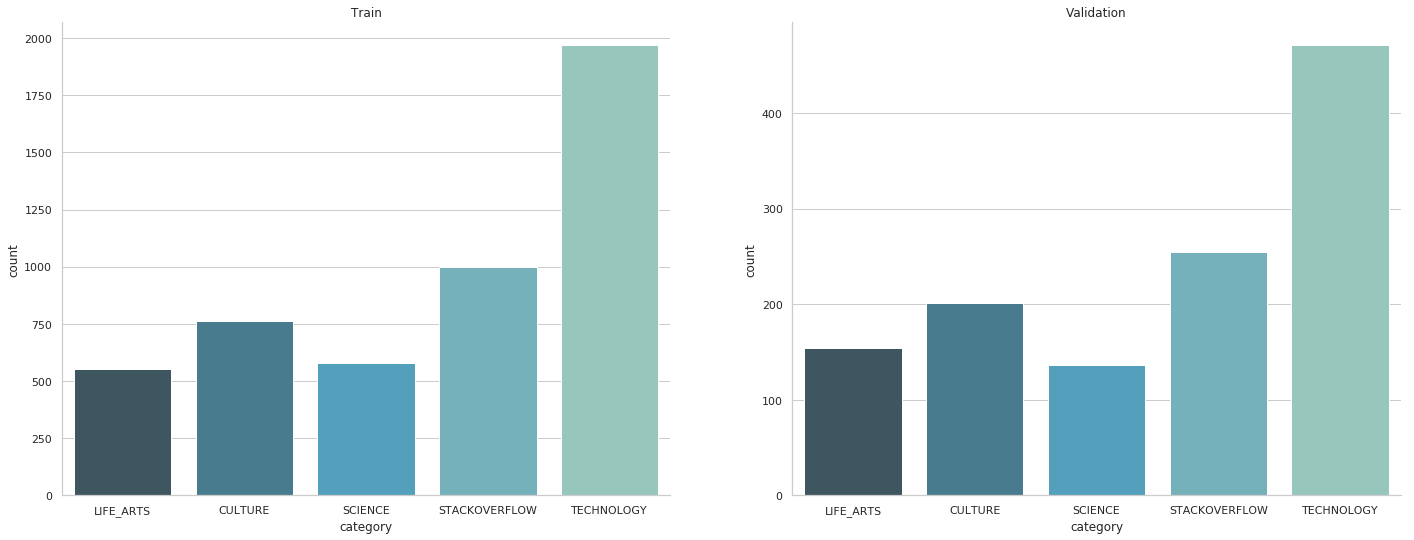

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8.7))
sns.countplot(x="category", data=train, palette="GnBu_d", order=category_cols, ax=ax1).set_title('Train')
sns.countplot(x="category", data=validation, palette="GnBu_d", order=category_cols, ax=ax2).set_title('Validation')
sns.despine()
plt.show()

## Label distribution

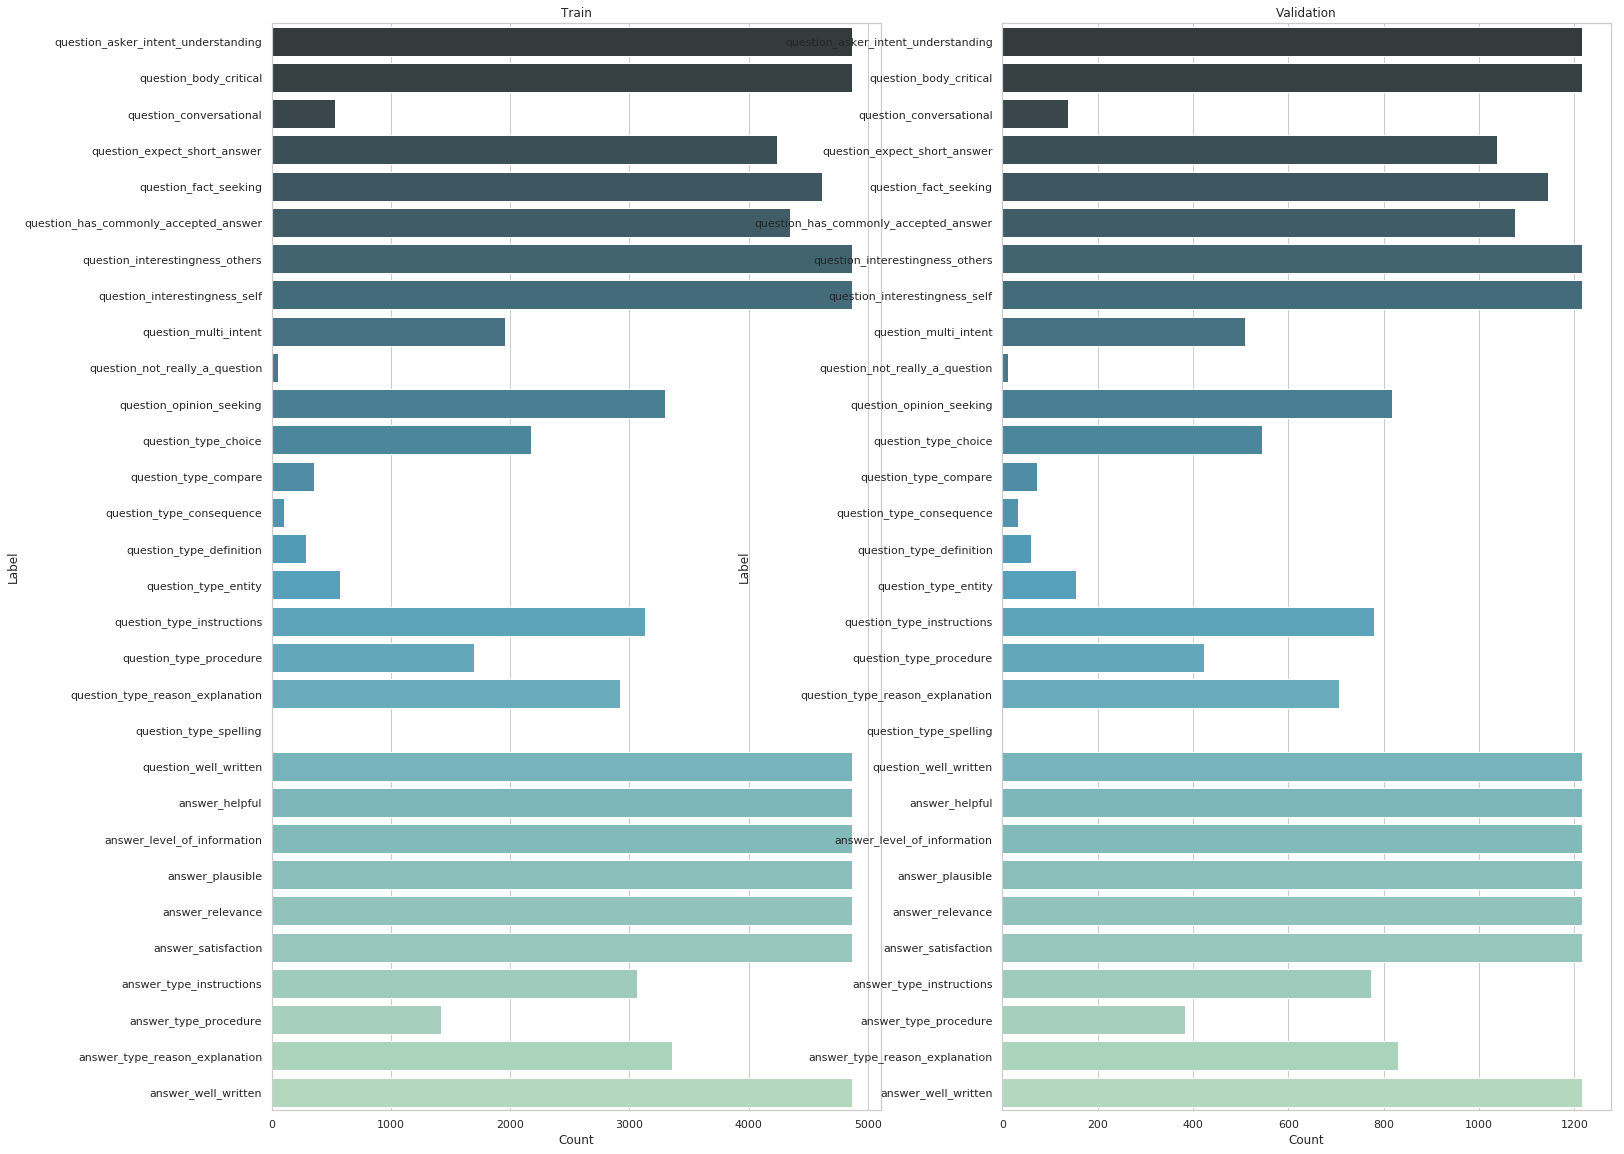

,Label,Train count,Validation count
0,question_asker_intent_understanding,4863,1216
1,question_body_critical,4863,1216
2,question_conversational,533,137
3,question_expect_short_answer,4236,1037
4,question_fact_seeking,4619,1145
5,question_has_commonly_accepted_answer,4346,1076
6,question_interestingness_others,4863,1216
7,question_interestingness_self,4863,1216
8,question_multi_intent,1953,509
9,question_not_really_a_question,55,11


In [5]:
train_lbls = []
validation_lbls = []
for col in target_cols:
    train_lbls.append([col, len(train[train[col] > 0])])
    validation_lbls.append([col, len(validation[validation[col] > 0])])
    
train_lbls = pd.DataFrame(train_lbls, columns=['Label', 'Count'])
validation_lbls = pd.DataFrame(validation_lbls, columns=['Label', 'Count'])
sumary_lbl = train_lbls.merge(validation_lbls, on='Label')
sumary_lbl.columns = ['Label', 'Train count', 'Validation count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 20))
sns.barplot(y='Label', x='Count', data=train_lbls, palette="GnBu_d", ax=ax1).set_title('Train')
sns.barplot(y='Label', x='Count', data=validation_lbls, palette="GnBu_d", ax=ax2).set_title('Validation')
plt.show()

display(sumary_lbl)

## Duplicated question

In [6]:
train_unique_qt = set(train['question_title'].unique())
validation_unique_qt = set(validation['question_title'].unique())

print('Duplicated questions %s' % len(train_unique_qt & validation_unique_qt))

Duplicated questions 693


## Output hold-out set

In [7]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)
train_complete.to_csv('hold-out.csv', index=False)
display(train_complete.head())

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
2440,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1966,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
951,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
4256,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
1355,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


# 3-Fold split

In [8]:
folds = MultilabelStratifiedKFold(n_splits=3, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df[target_cols])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 4051, Validation size 2028
Fold: 2, Train size: 4063, Validation size 2016
Fold: 3, Train size: 4044, Validation size 2035


## Category distribution

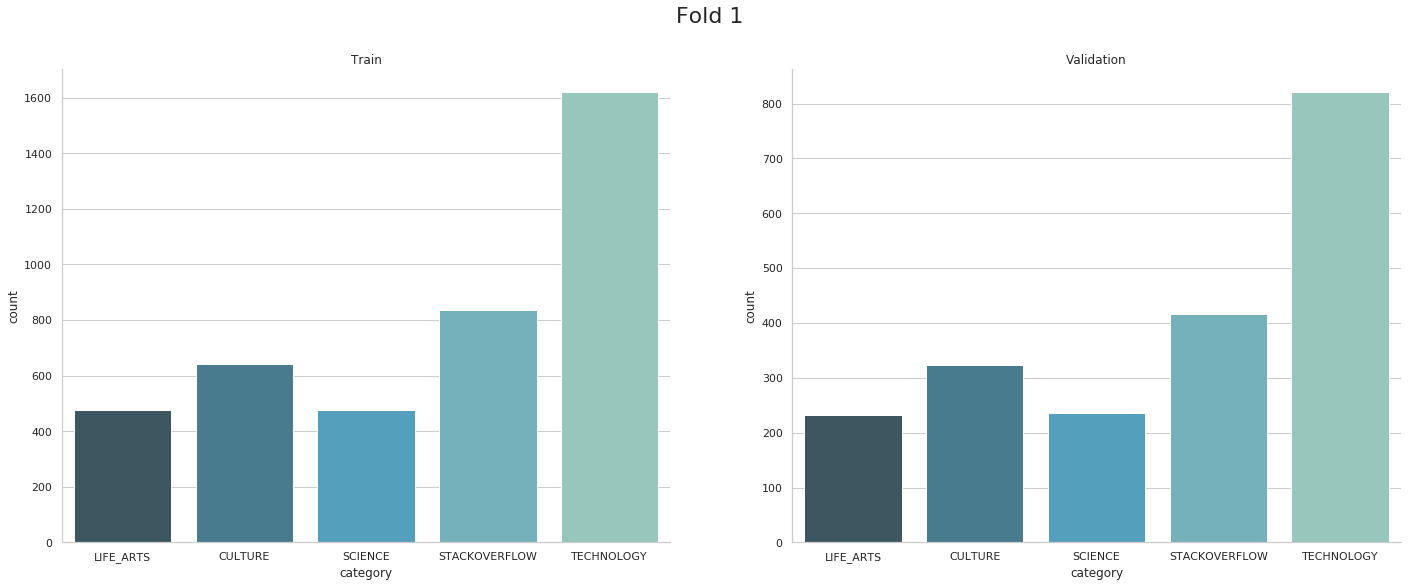

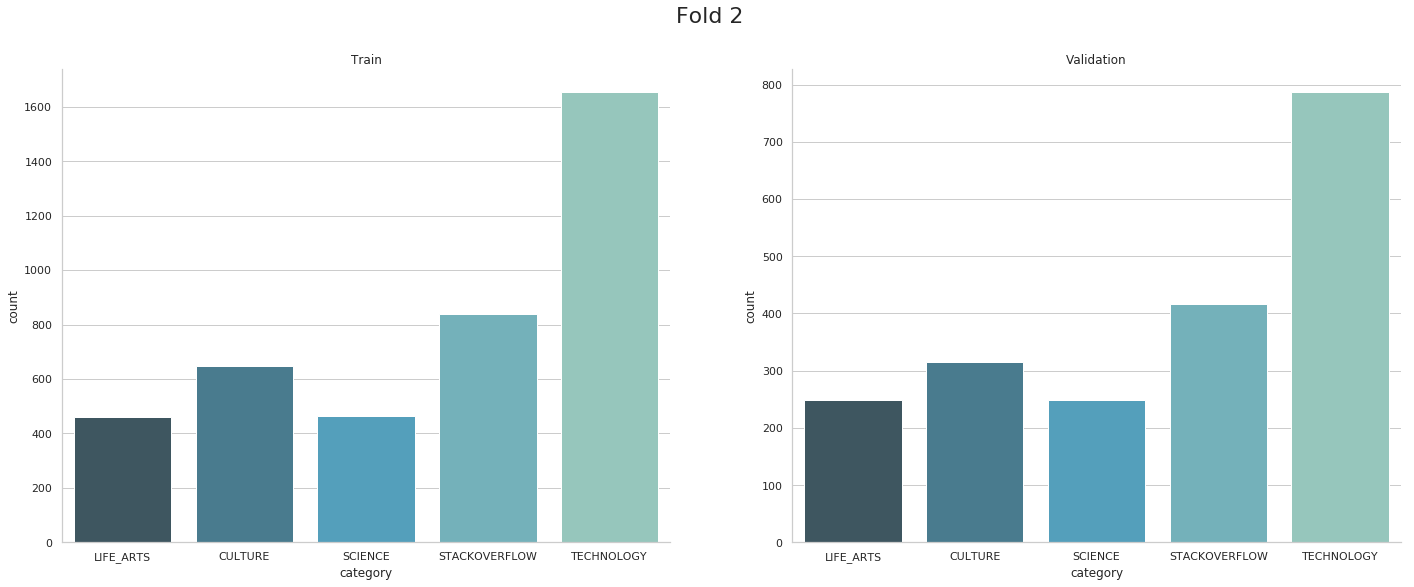

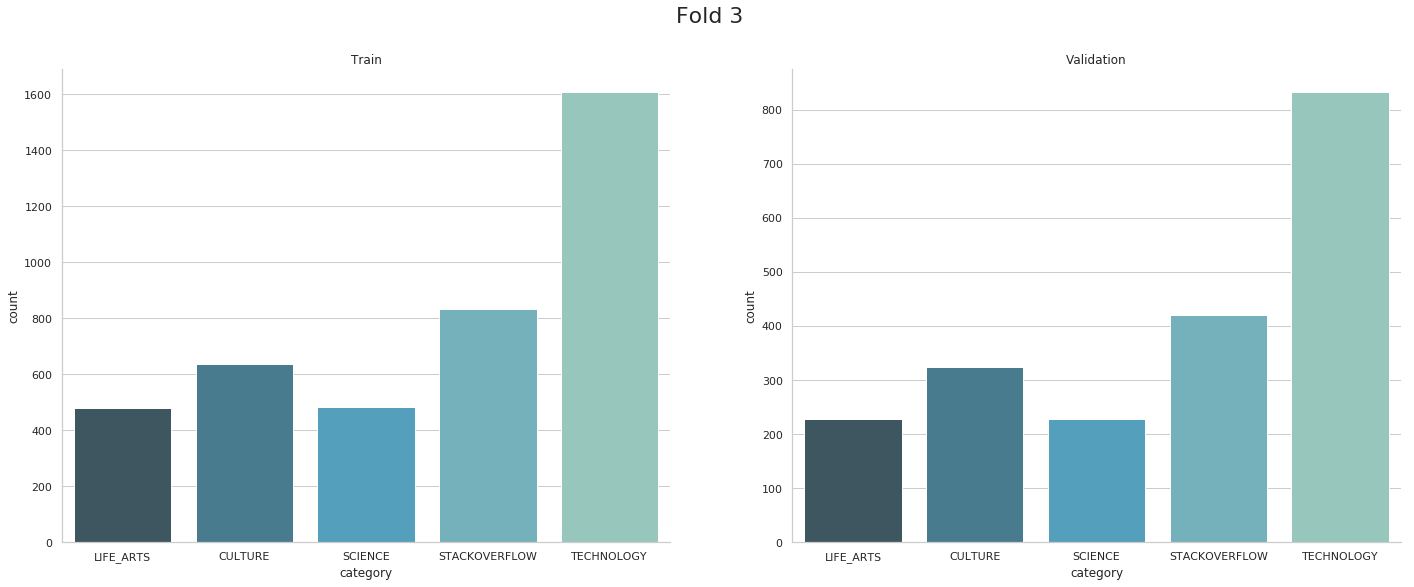

In [9]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8.7))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="category", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", order=category_cols, ax=ax1).set_title('Train')
    sns.countplot(x="category", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", order=category_cols, ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

## Label distribution

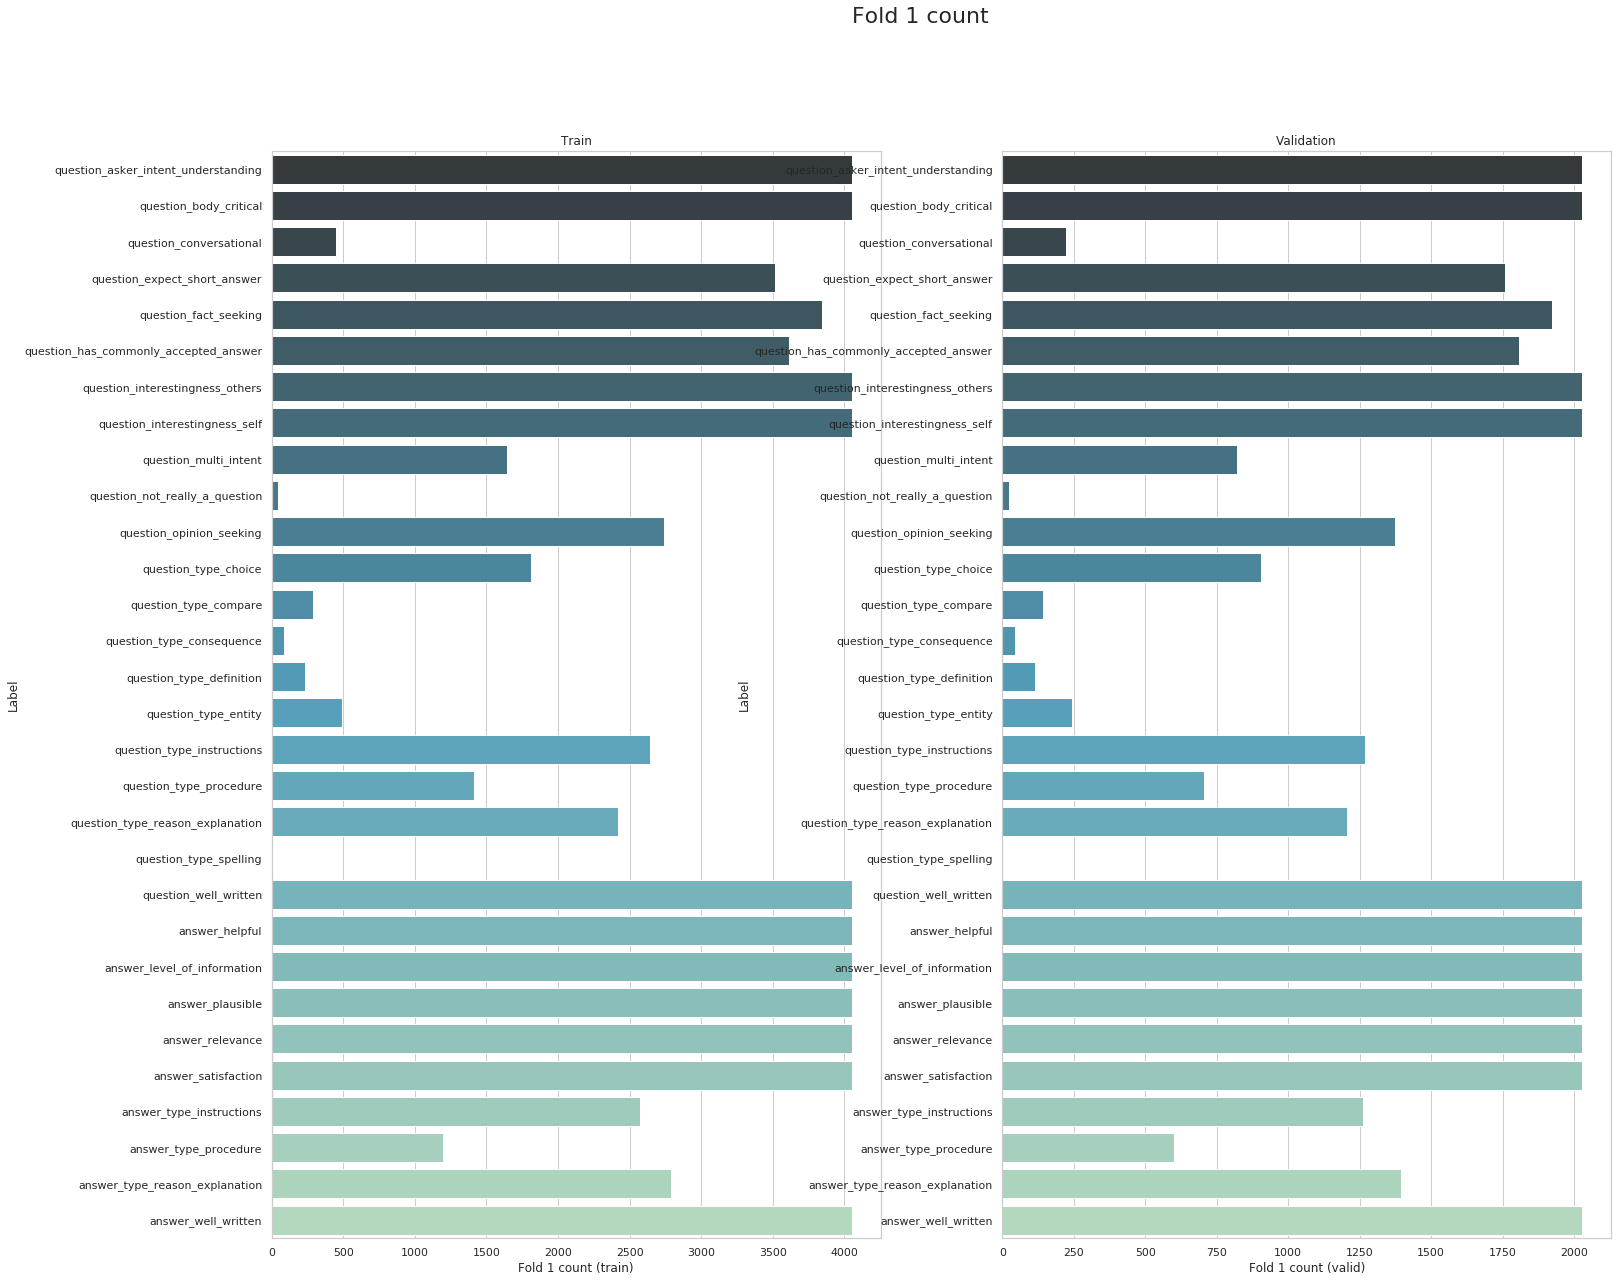

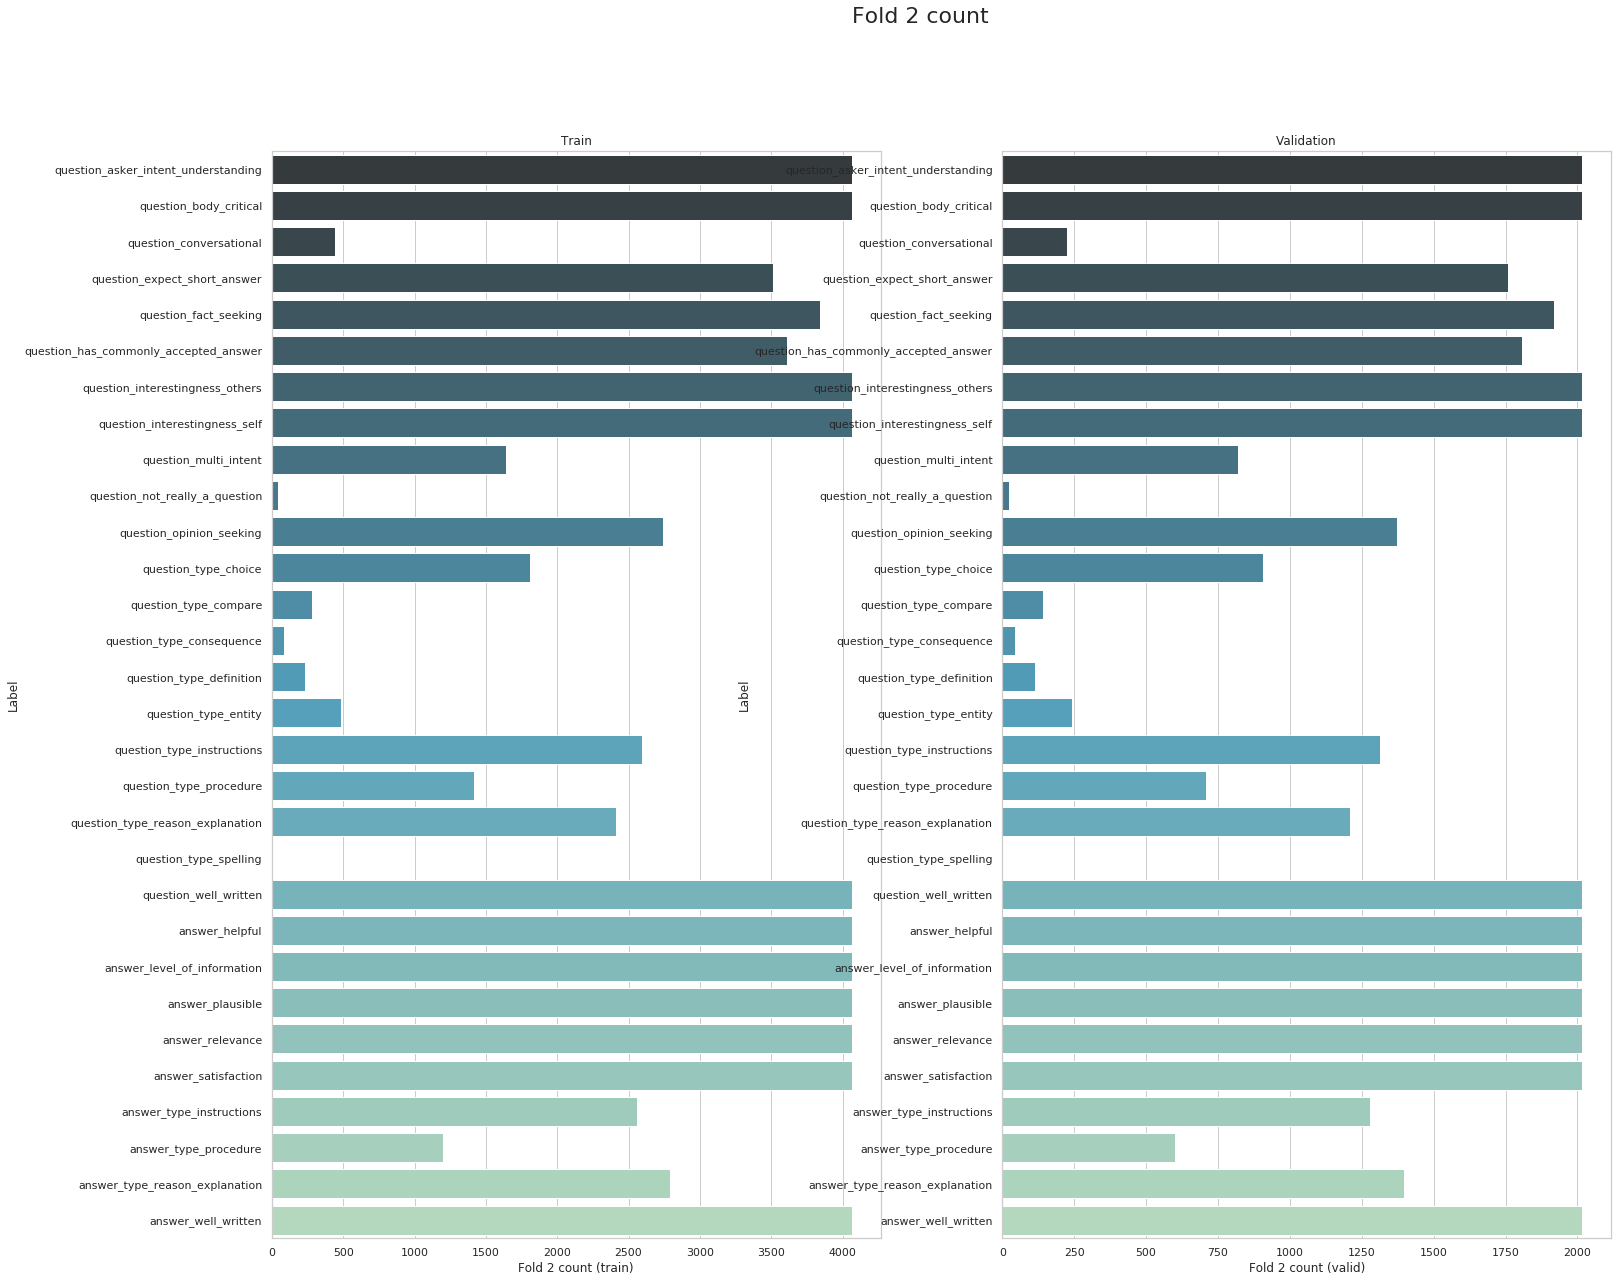

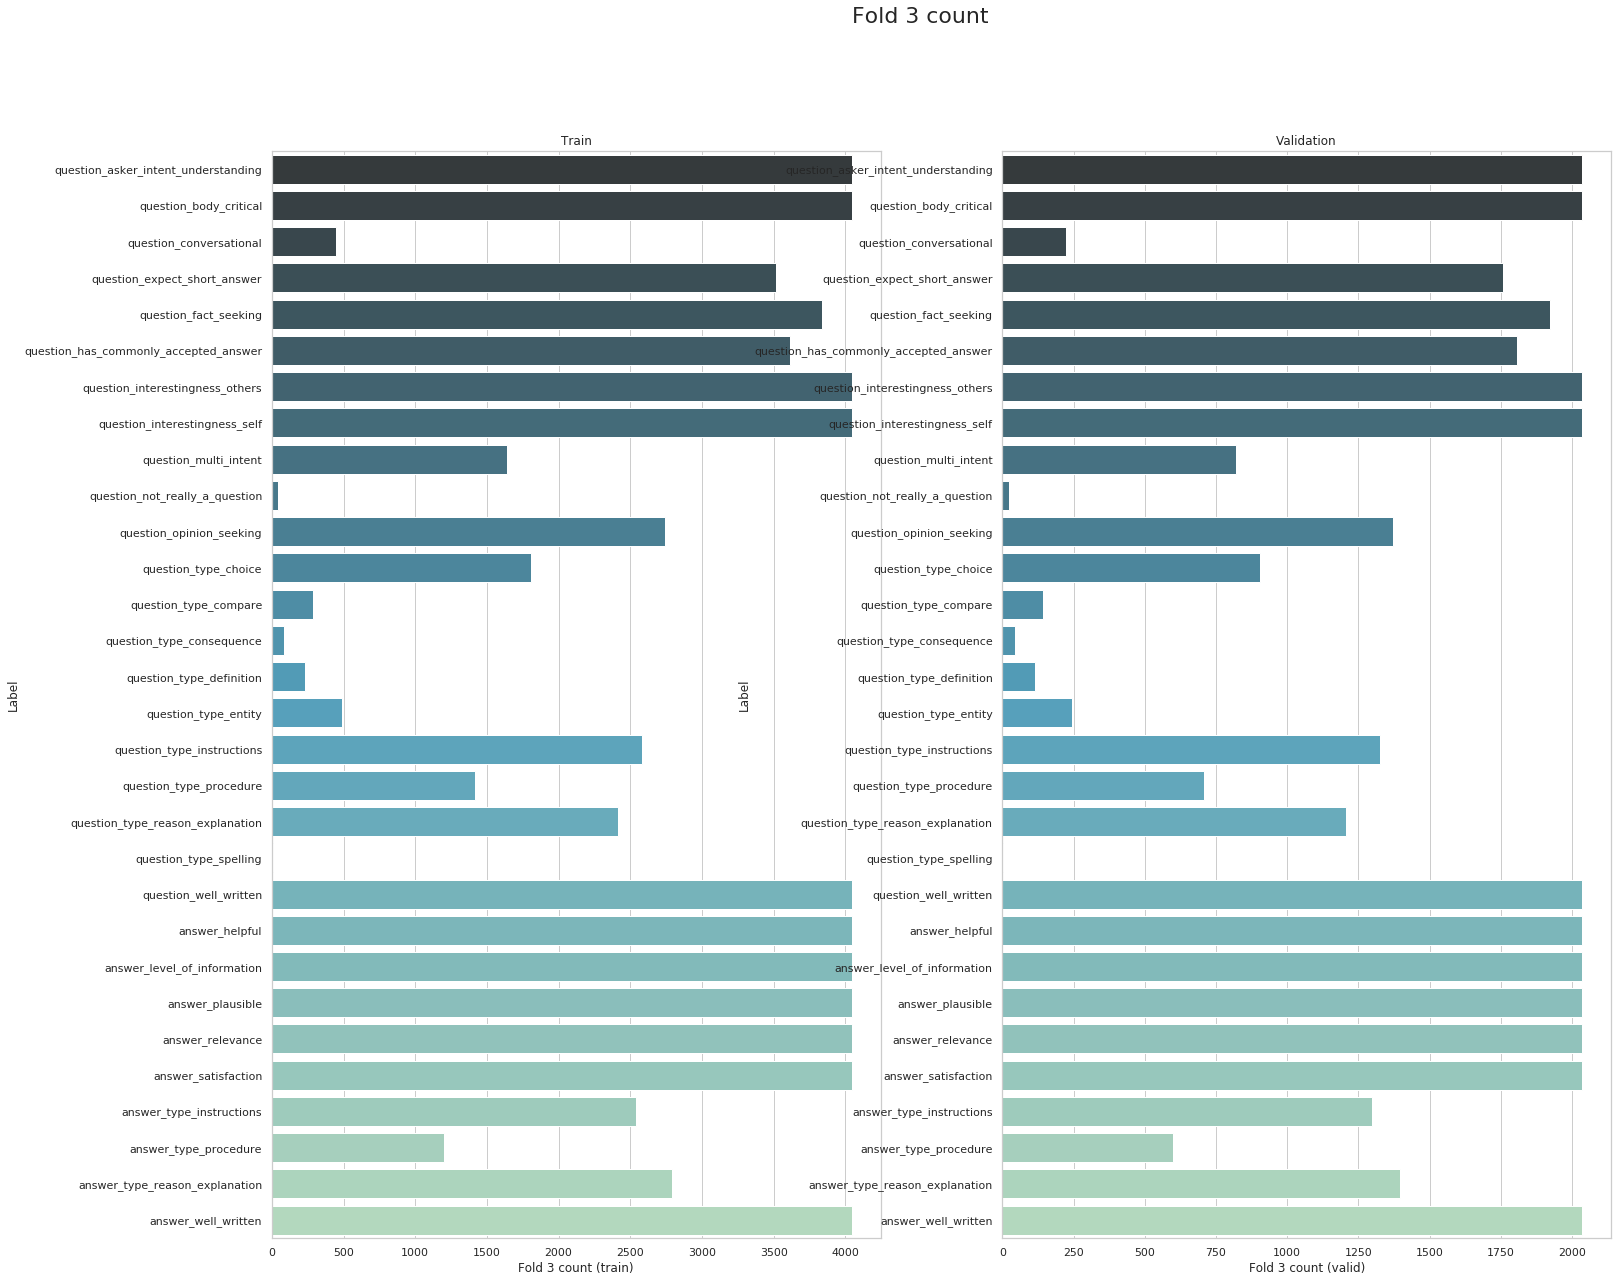

,Label,Fold 1 count (train),Fold 1 count (valid),Fold 2 count (train),Fold 2 count (valid),Fold 3 count (train),Fold 3 count (valid)
0,question_asker_intent_understanding,4051.0,2028.0,4063.0,2016.0,4044.0,2035.0
1,question_body_critical,4051.0,2028.0,4063.0,2016.0,4044.0,2035.0
2,question_conversational,447.0,223.0,446.0,224.0,447.0,223.0
3,question_expect_short_answer,3515.0,1758.0,3515.0,1758.0,3516.0,1757.0
4,question_fact_seeking,3842.0,1922.0,3845.0,1919.0,3841.0,1923.0
5,question_has_commonly_accepted_answer,3615.0,1807.0,3614.0,1808.0,3615.0,1807.0
6,question_interestingness_others,4051.0,2028.0,4063.0,2016.0,4044.0,2035.0
7,question_interestingness_self,4051.0,2028.0,4063.0,2016.0,4044.0,2035.0
8,question_multi_intent,1642.0,820.0,1641.0,821.0,1641.0,821.0
9,question_not_really_a_question,44.0,22.0,44.0,22.0,44.0,22.0


In [10]:
sumary_lbl = pd.DataFrame(target_cols, columns=['Label'])
for fold_n in range(folds.n_splits):
    fold_n += 1
    for col in target_cols:
        sumary_lbl.loc[sumary_lbl['Label'] == col, 'Fold %s count (train)' % fold_n] = len(train_df[(train_df[('fold_%s' % fold_n)] == 'train') & (train_df[col] > 0)])
        sumary_lbl.loc[sumary_lbl['Label'] == col, 'Fold %s count (valid)' % fold_n] = len(train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & (train_df[col] > 0)])
            

for fold_n in range(folds.n_splits):
    fold_n += 1
    fold_col = 'Fold %s count' % fold_n
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 20))
    fig.suptitle(fold_col, fontsize=22)
    sns.barplot(y='Label', x=fold_col + ' (train)', data=sumary_lbl, palette="GnBu_d", ax=ax1).set_title('Train')
    sns.barplot(y='Label', x=fold_col + ' (valid)', data=sumary_lbl, palette="GnBu_d", ax=ax2).set_title('Validation')
    plt.show()

display(sumary_lbl)

## Duplicated question & answer

In [11]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    train_unique_qt = set(train_df[train_df[('fold_%s' % fold_n)] == 'train']['question_title'].unique())
    validation_unique_qt = set(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['question_title'].unique())

    print('Fold %d' % fold_n)
    print('Duplicated questions %s' % len(train_unique_qt & validation_unique_qt))

Fold 1
Duplicated questions 951
Fold 2
Duplicated questions 965
Fold 3
Duplicated questions 946


## Output 3-fold set

In [12]:
train_df.to_csv('3-fold.csv', index=False)
display(train_df.head())

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,fold_1,fold_2,fold_3
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,train,train,validation
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,train,validation,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,validation,train,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000,train,train,validation
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000,train,validation,train


# 5-Fold split

In [13]:
folds = MultilabelStratifiedKFold(n_splits=5, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df[target_cols])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 4864, Validation size 1215
Fold: 2, Train size: 4864, Validation size 1215
Fold: 3, Train size: 4859, Validation size 1220
Fold: 4, Train size: 4865, Validation size 1214
Fold: 5, Train size: 4864, Validation size 1215


## Category distribution

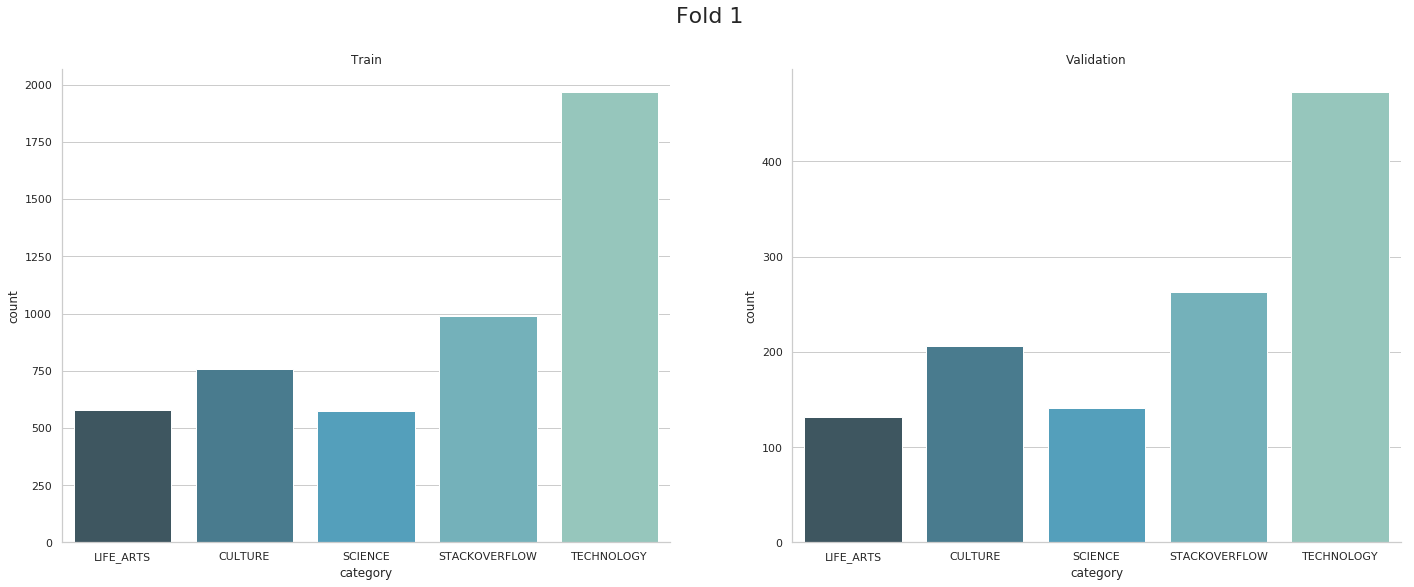

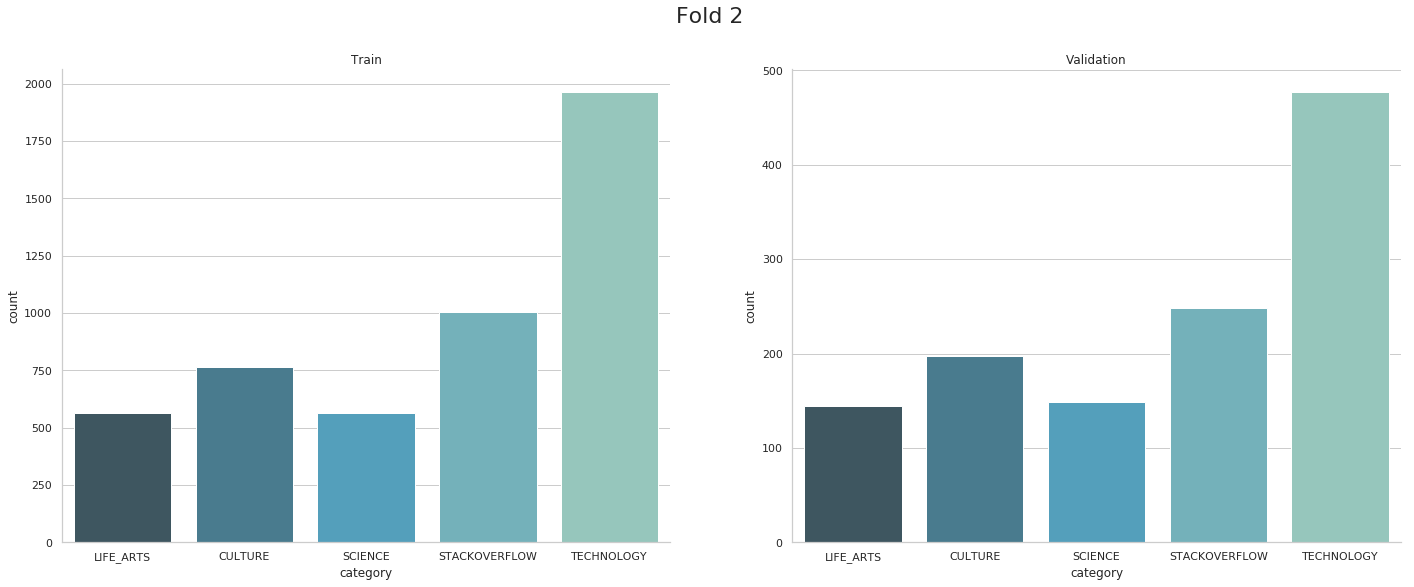

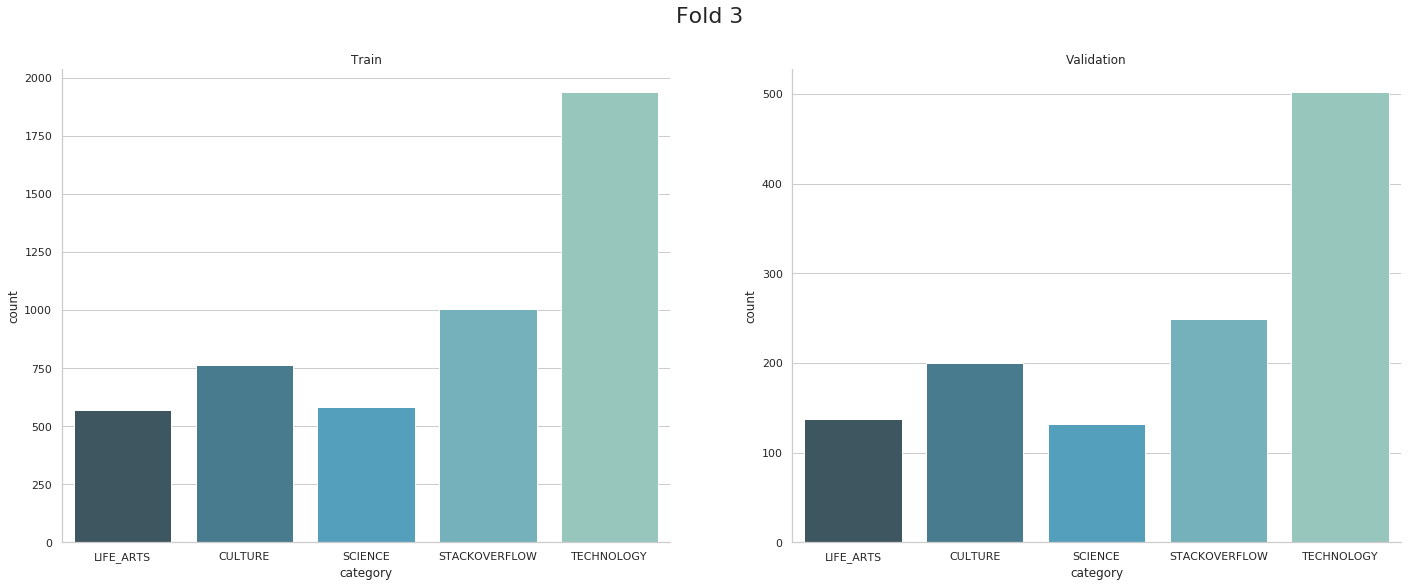

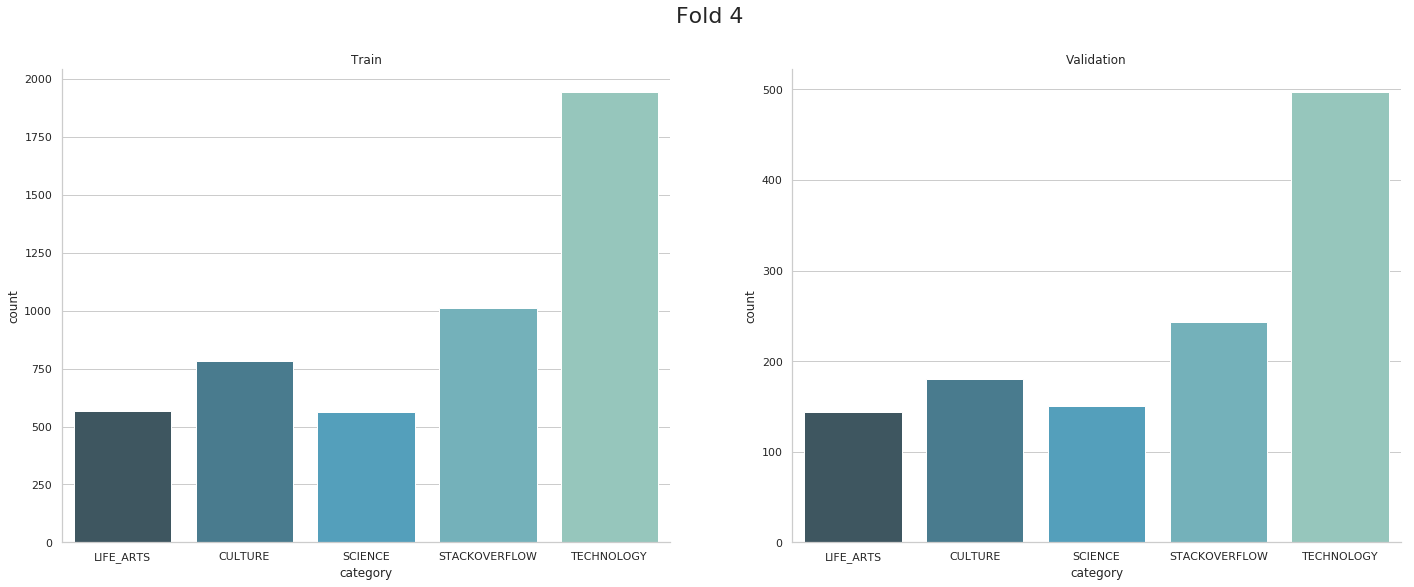

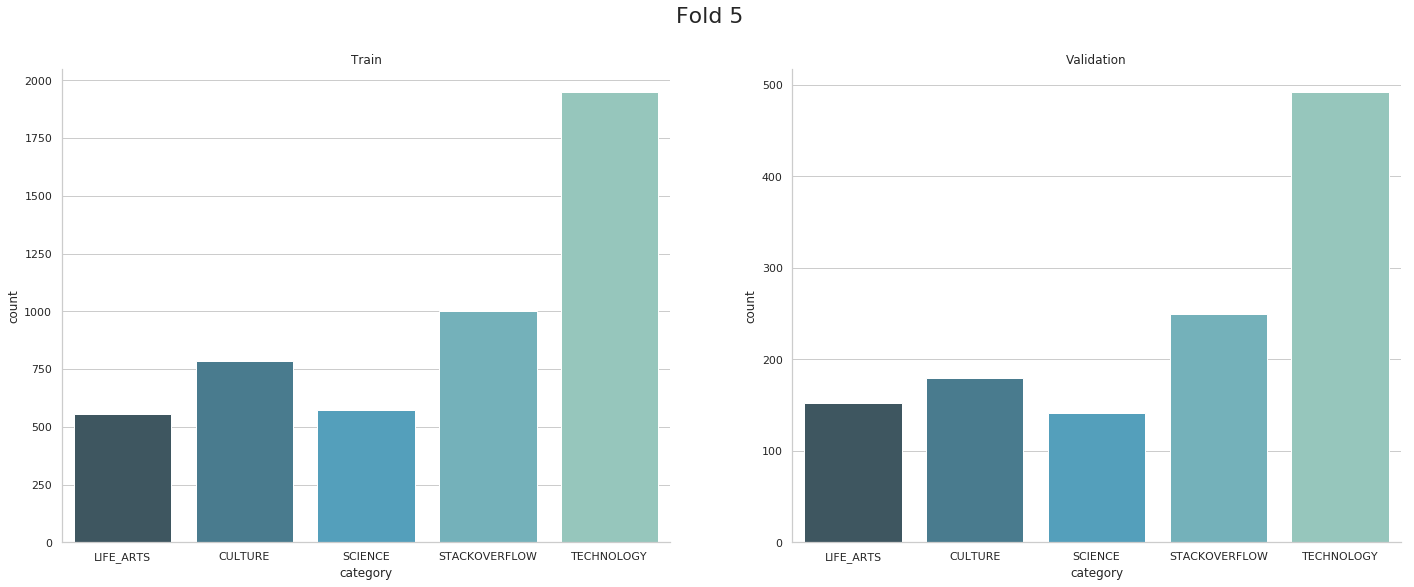

In [14]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8.7))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="category", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", order=category_cols, ax=ax1).set_title('Train')
    sns.countplot(x="category", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", order=category_cols, ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

## Label distribution

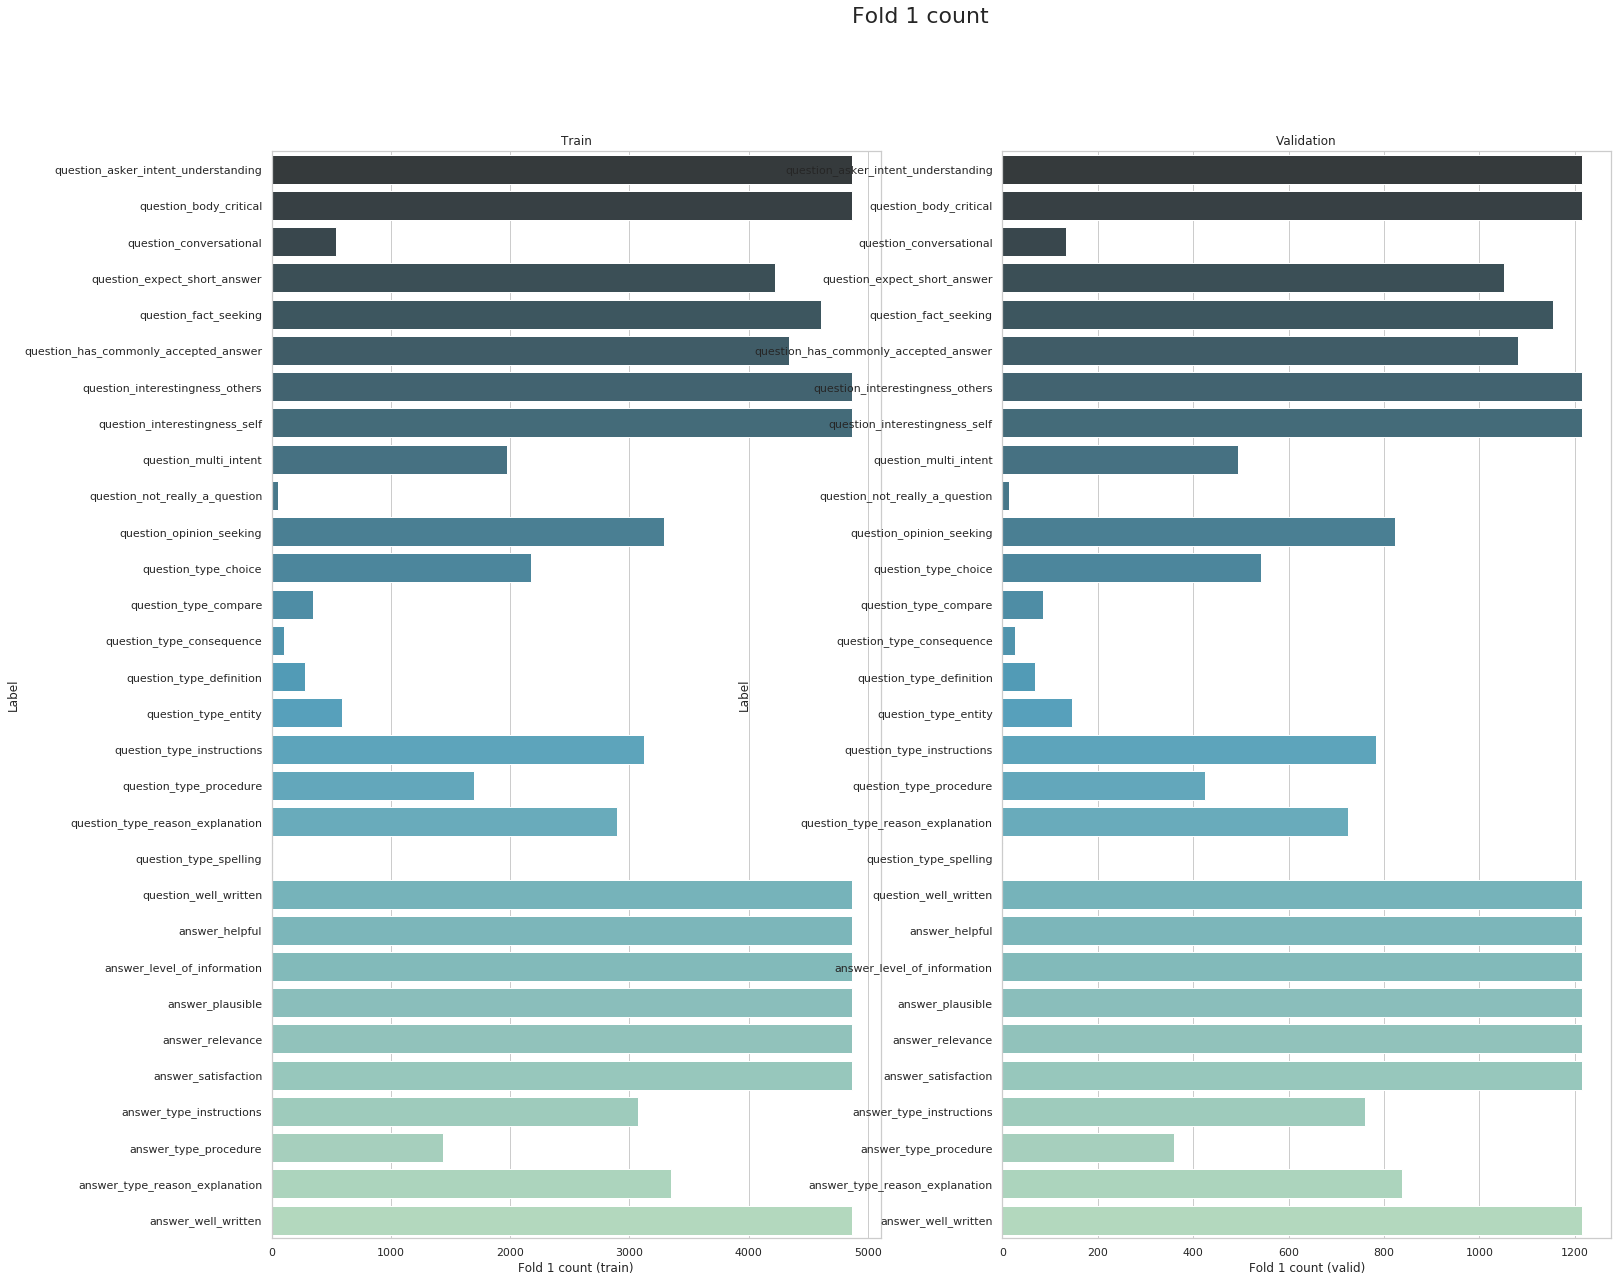

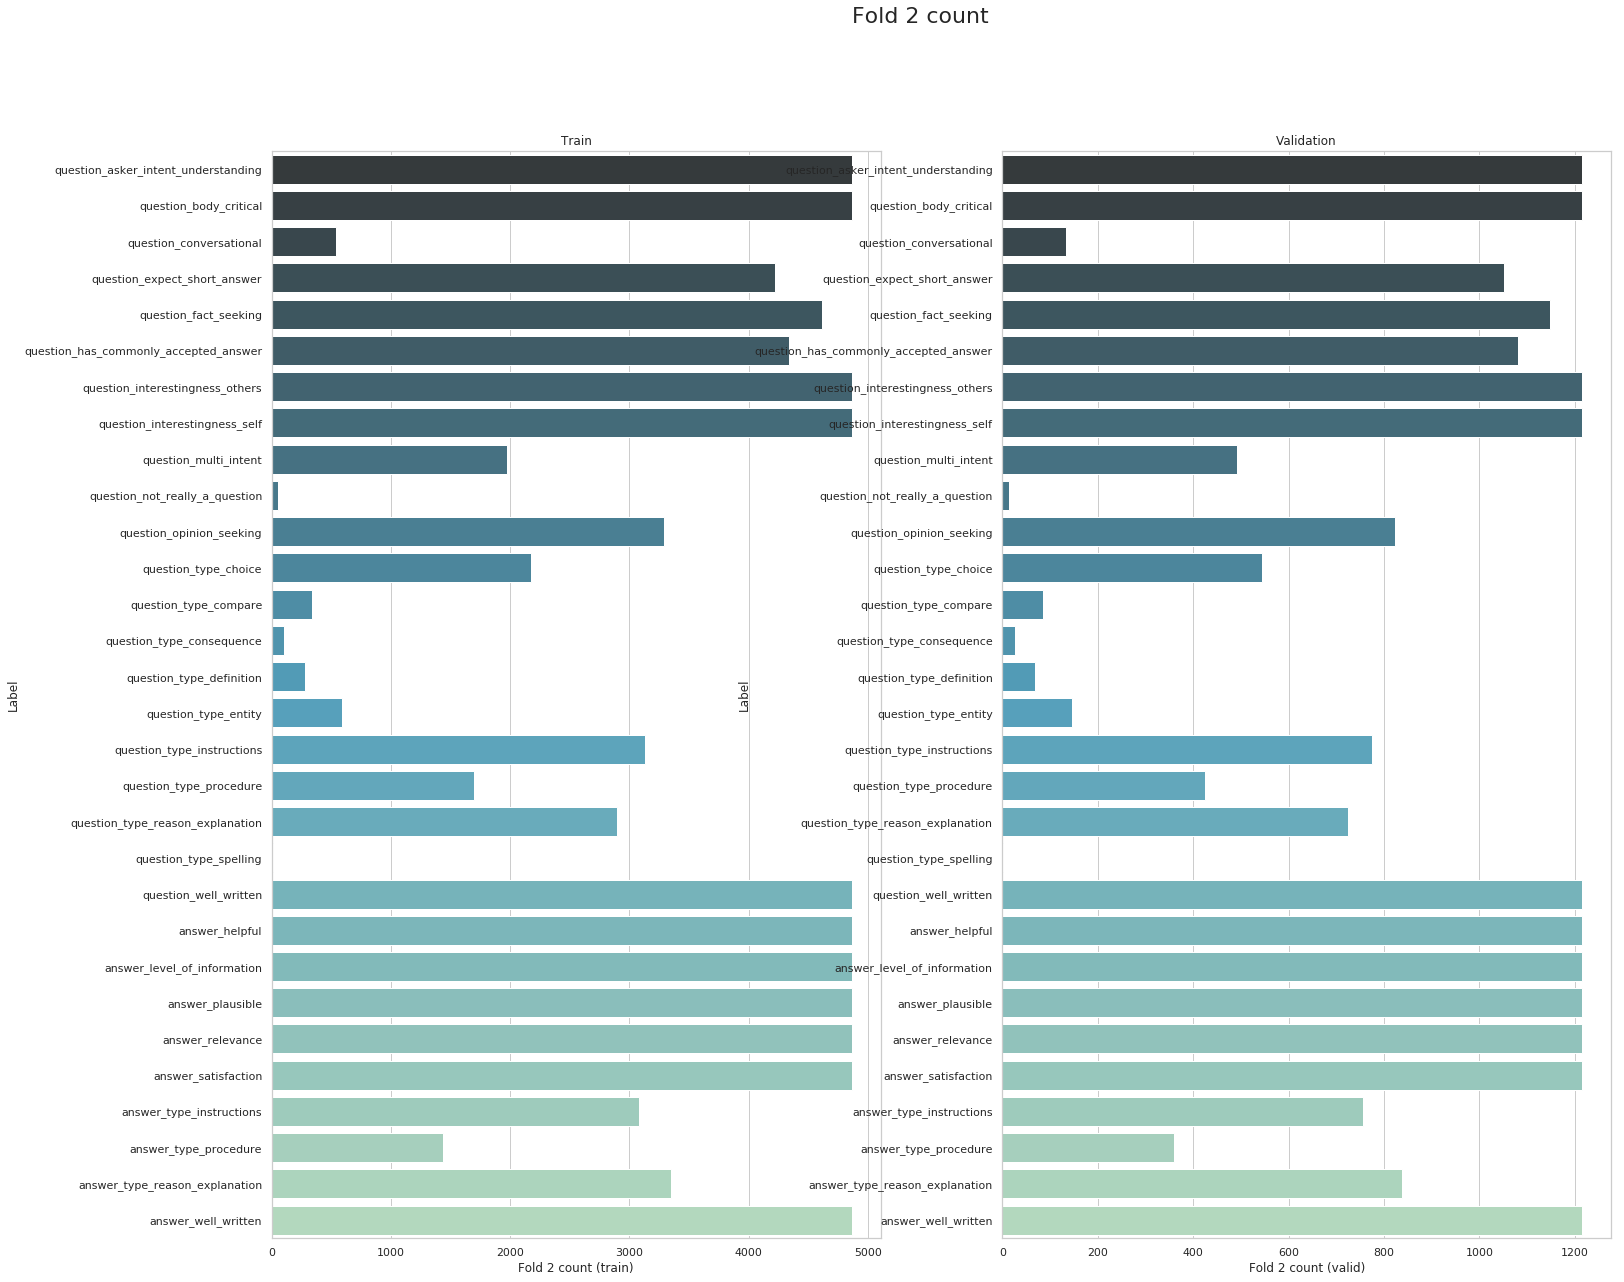

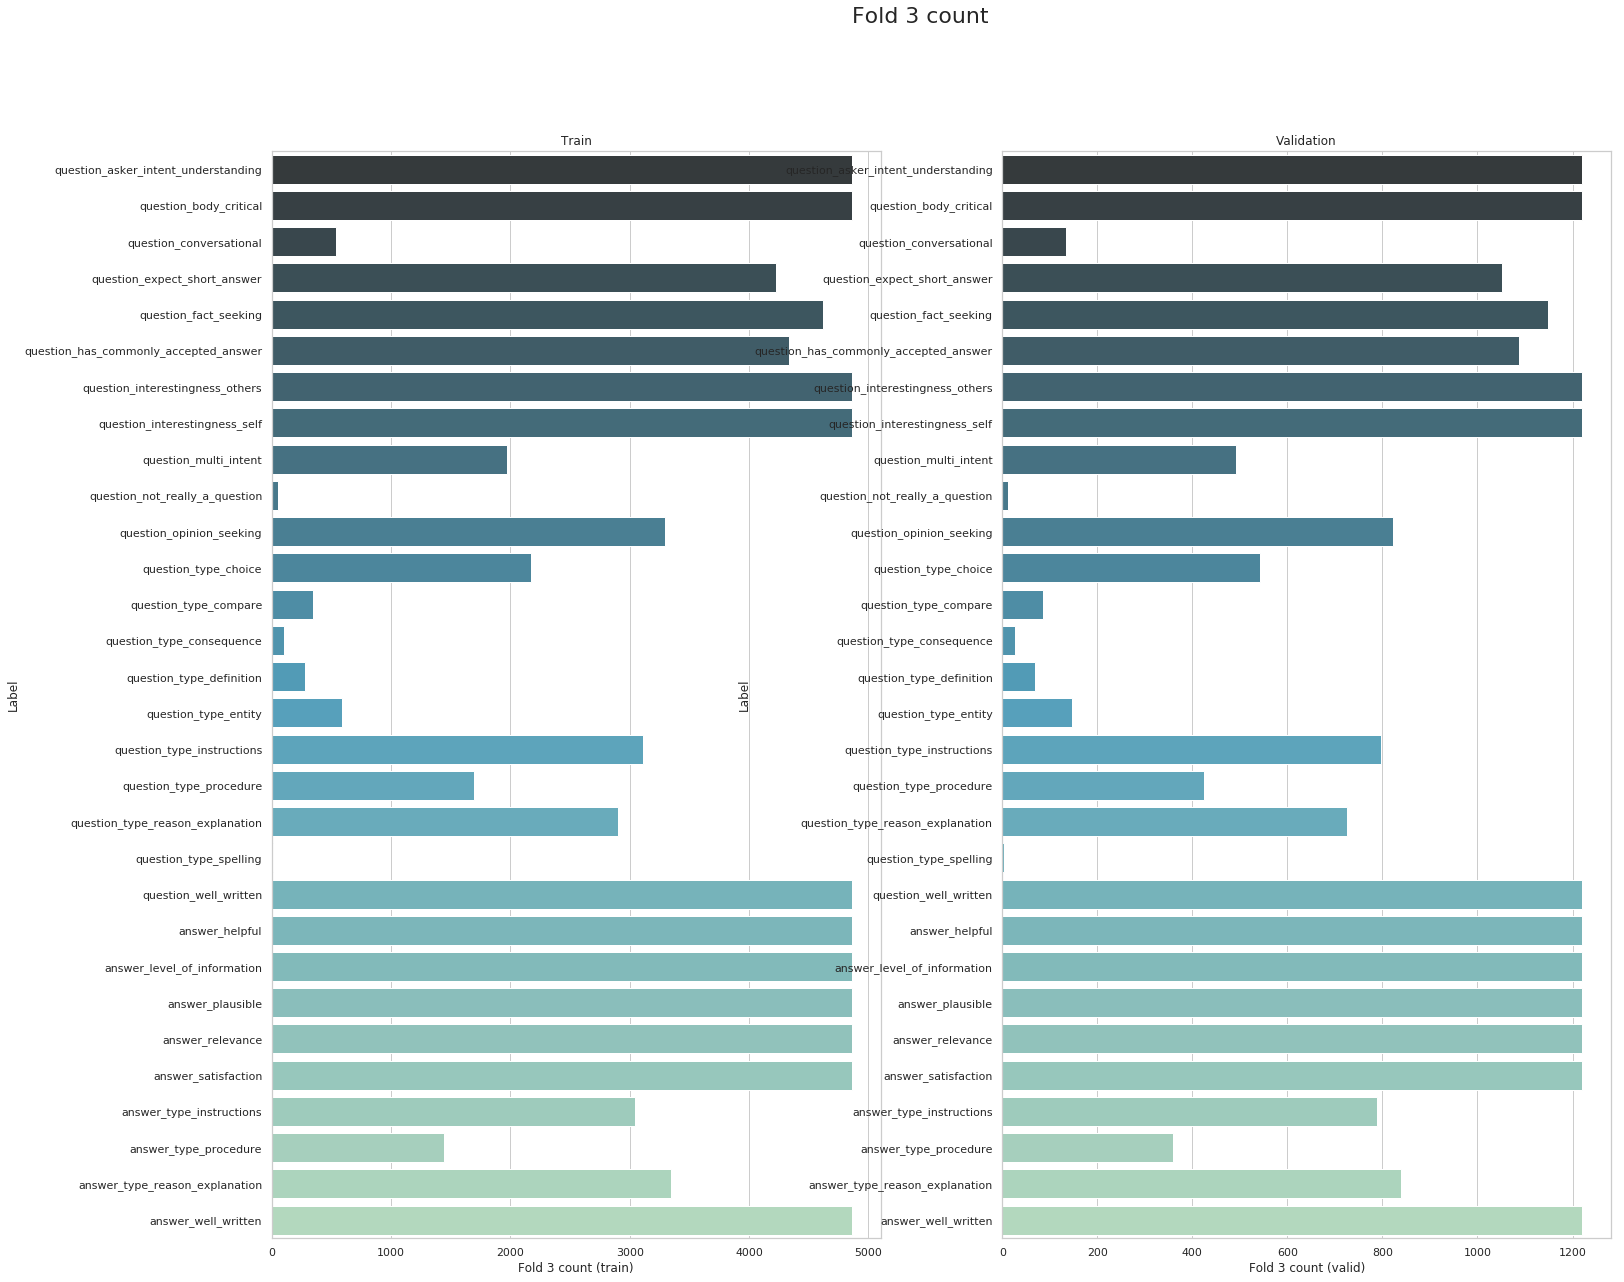

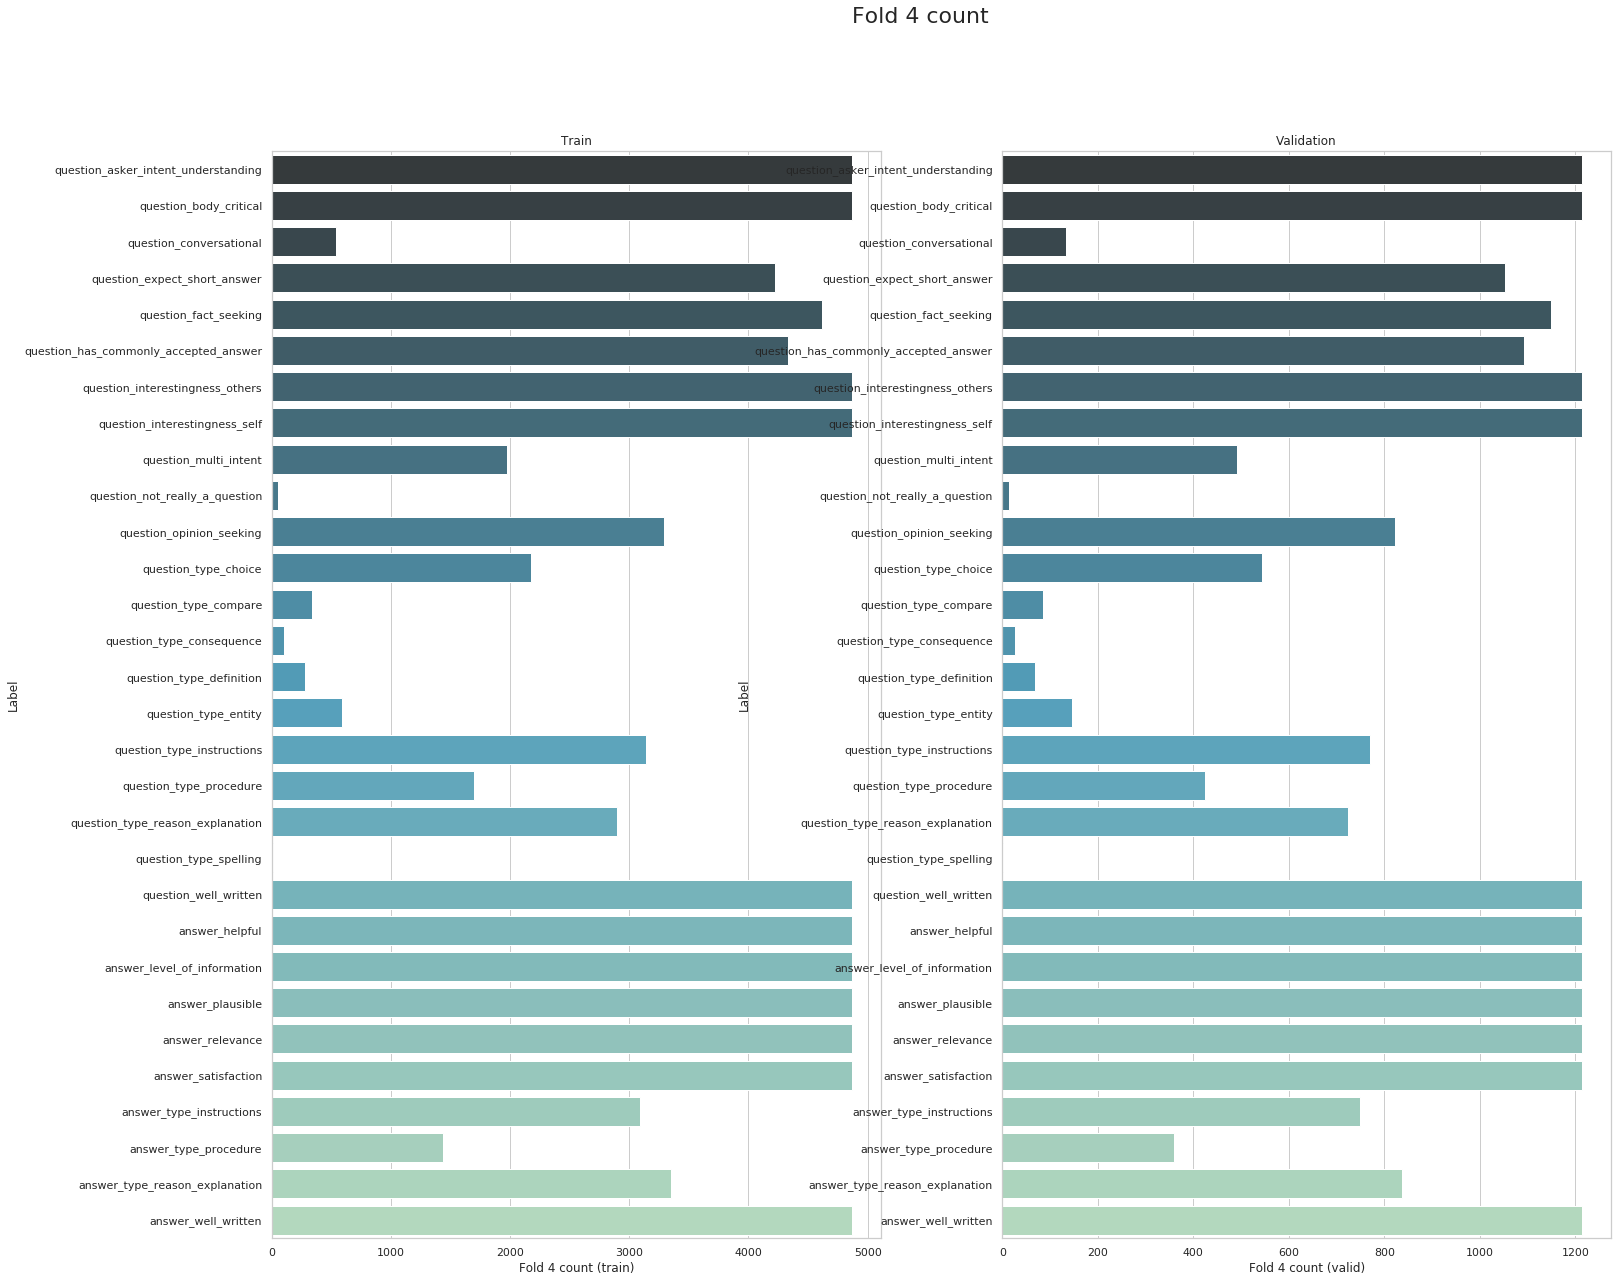

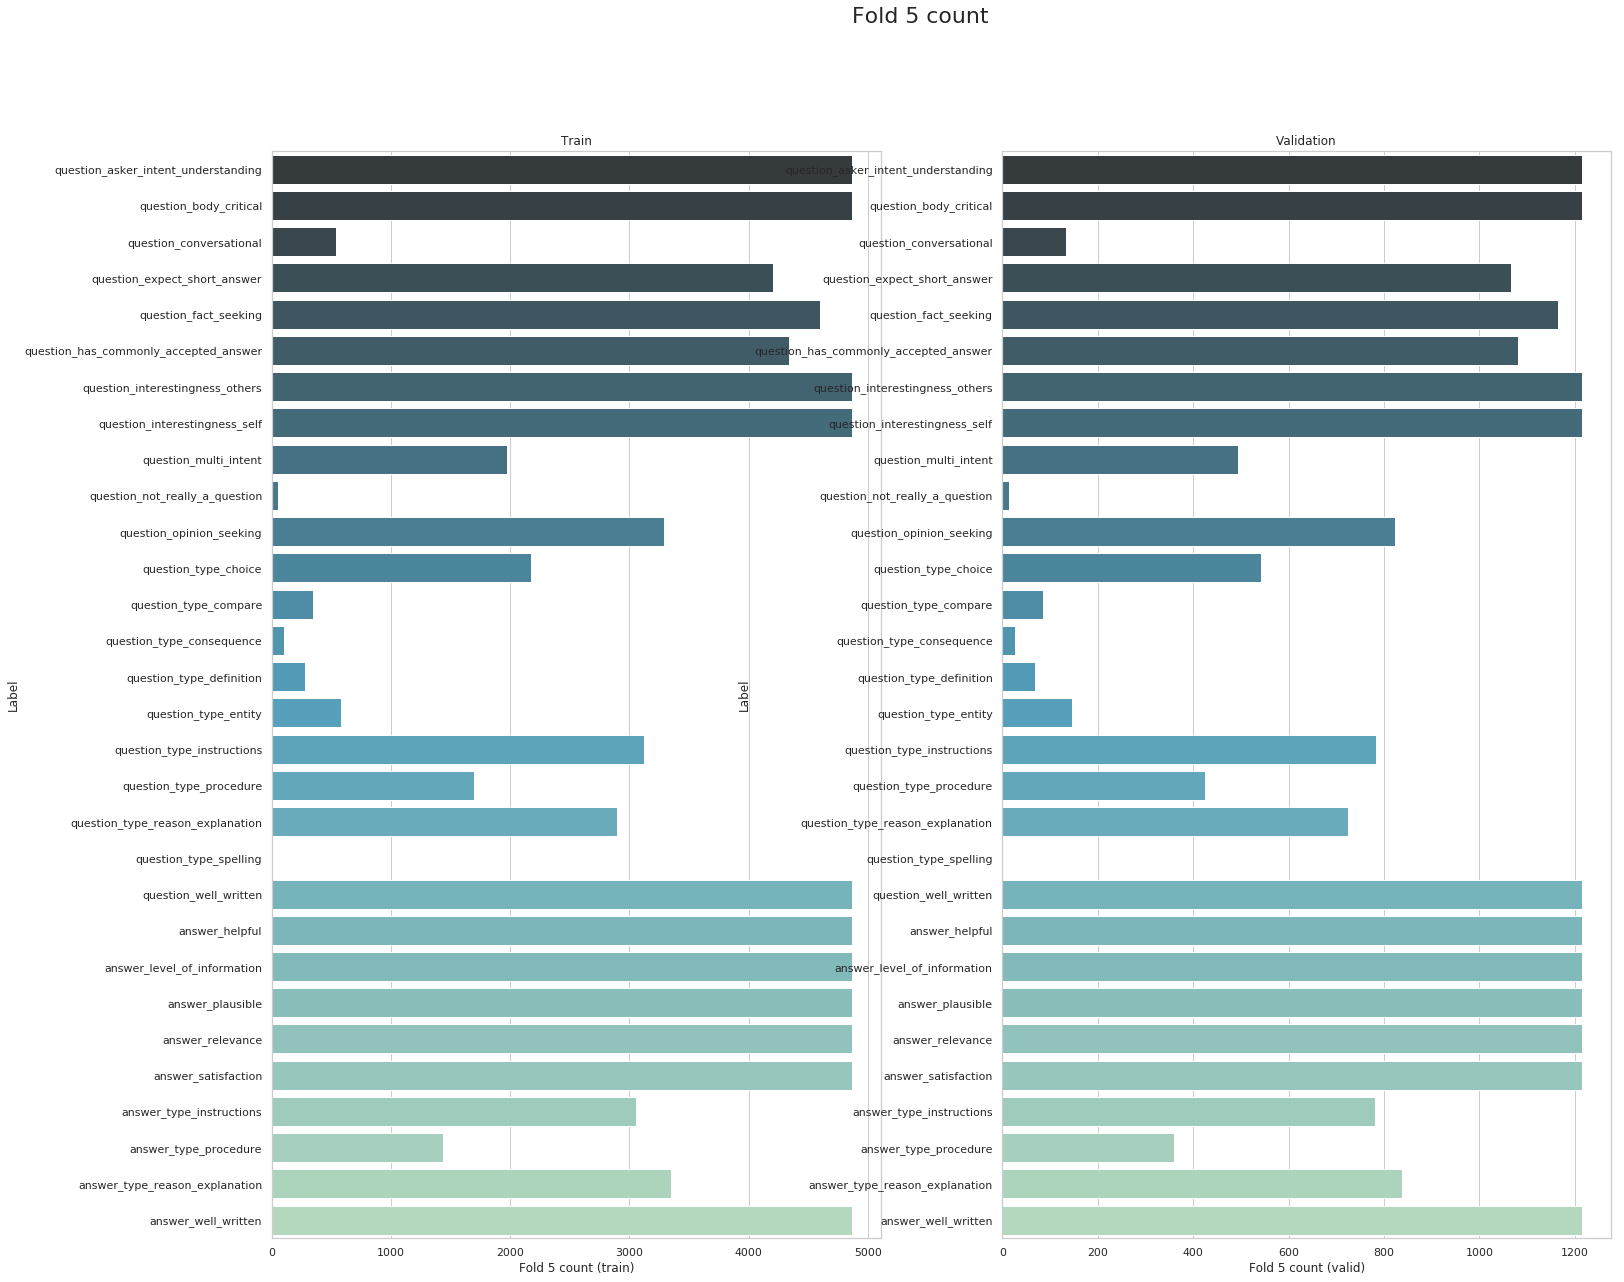

,Label,Fold 1 count (train),Fold 1 count (valid),Fold 2 count (train),Fold 2 count (valid),Fold 3 count (train),Fold 3 count (valid),Fold 4 count (train),Fold 4 count (valid),Fold 5 count (train),Fold 5 count (valid)
0,question_asker_intent_understanding,4864.0,1215.0,4864.0,1215.0,4859.0,1220.0,4865.0,1214.0,4864.0,1215.0
1,question_body_critical,4864.0,1215.0,4864.0,1215.0,4859.0,1220.0,4865.0,1214.0,4864.0,1215.0
2,question_conversational,536.0,134.0,536.0,134.0,536.0,134.0,536.0,134.0,536.0,134.0
3,question_expect_short_answer,4221.0,1052.0,4221.0,1052.0,4222.0,1051.0,4221.0,1052.0,4207.0,1066.0
4,question_fact_seeking,4610.0,1154.0,4616.0,1148.0,4616.0,1148.0,4615.0,1149.0,4599.0,1165.0
5,question_has_commonly_accepted_answer,4341.0,1081.0,4342.0,1080.0,4335.0,1087.0,4329.0,1093.0,4341.0,1081.0
6,question_interestingness_others,4864.0,1215.0,4864.0,1215.0,4859.0,1220.0,4865.0,1214.0,4864.0,1215.0
7,question_interestingness_self,4864.0,1215.0,4864.0,1215.0,4859.0,1220.0,4865.0,1214.0,4864.0,1215.0
8,question_multi_intent,1969.0,493.0,1970.0,492.0,1970.0,492.0,1970.0,492.0,1969.0,493.0
9,question_not_really_a_question,53.0,13.0,52.0,14.0,53.0,13.0,53.0,13.0,53.0,13.0


In [15]:
sumary_lbl = pd.DataFrame(target_cols, columns=['Label'])
for fold_n in range(folds.n_splits):
    fold_n += 1
    for col in target_cols:
        sumary_lbl.loc[sumary_lbl['Label'] == col, 'Fold %s count (train)' % fold_n] = len(train_df[(train_df[('fold_%s' % fold_n)] == 'train') & (train_df[col] > 0)])
        sumary_lbl.loc[sumary_lbl['Label'] == col, 'Fold %s count (valid)' % fold_n] = len(train_df[(train_df[('fold_%s' % fold_n)] == 'validation') & (train_df[col] > 0)])
            

for fold_n in range(folds.n_splits):
    fold_n += 1
    fold_col = 'Fold %s count' % fold_n
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 20))
    fig.suptitle(fold_col, fontsize=22)
    sns.barplot(y='Label', x=fold_col + ' (train)', data=sumary_lbl, palette="GnBu_d", ax=ax1).set_title('Train')
    sns.barplot(y='Label', x=fold_col + ' (valid)', data=sumary_lbl, palette="GnBu_d", ax=ax2).set_title('Validation')
    plt.show()

display(sumary_lbl)

## Duplicated question & answer

In [16]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    train_unique_qt = set(train_df[train_df[('fold_%s' % fold_n)] == 'train']['question_title'].unique())
    validation_unique_qt = set(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['question_title'].unique())
    
    print('Fold %d' % fold_n)
    print('Duplicated questions %s' % len(train_unique_qt & validation_unique_qt))

Fold 1
Duplicated questions 684
Fold 2
Duplicated questions 672
Fold 3
Duplicated questions 682
Fold 4
Duplicated questions 683
Fold 5
Duplicated questions 688


## Output 5-fold set

In [17]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,0.800000,1.0,0.000000,0.000000,1.000000,train,train,train,validation,train
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.666667,0.0,0.000000,0.666667,0.888889,validation,train,train,train,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.666667,0.0,0.333333,1.000000,0.888889,train,train,validation,train,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.800000,0.0,0.000000,1.000000,1.000000,train,train,train,train,validation
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,0.800000,1.0,0.000000,1.000000,1.000000,validation,train,train,train,train
